# Создаем датасет 

In [1]:
import numpy as np
from bs4 import BeautifulSoup
from html.parser import HTMLParser
import requests
import json
import re
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [2]:
import time
start_time = time.time()

In [3]:
def extract_page_images(book_url, page):
    book_url = book_url + page
    book_html = requests.get(book_url).text
    soup = BeautifulSoup(book_html, 'html.parser')
    
    #ищем ссылки на картинки
    image_list = []
    img_atr_list = soup.findAll('img')
    
    # отбираем только те картинки, где изображена вещь без человека
    i = 0
    for img_atr in img_atr_list:
        link = img_atr['src']
        if  link[len(link)-4 :len(link)] == ".jpg" and link[0:15] == "https://storage"  and (img_atr['class'][0] + " " +  img_atr['class'][1]) != "img-fluid showback":
        
            #достаём картинку по запросу и переводим в np.array uint8
            response = requests.get(link)
            img = Image.open(BytesIO(response.content))
            img = np.array(img)
            image_list.append(img)
            
    return image_list

In [4]:
#создаём список ссылок на одежду
clothes_list = ["https://www.vsemayki.ru/catalog/group/man_tshirts?page=", 
                "https://www.vsemayki.ru/catalog/group/man_hoodies?page=",
                "https://www.vsemayki.ru/catalog/group/man_trousers_shorts?page="]
images_long = []

#проходимся по всем страницам с этими вещами
for clothes in clothes_list:
    for page in range(2, 52): 
        images_of_page_list = extract_page_images(clothes, str(page))
        images_long+=images_of_page_list

In [5]:
images = [i[13:-13,13:-13] for i in images_long]

In [6]:
print((time.time() - start_time)/60, 'мин')
start_time = time.time()

21.805865716934203 мин


# Строим рекомендацию

In [7]:
# создаем модель без последнего слоя
from keras.applications import VGG19
from keras.engine import Model
bm = VGG19(weights='imagenet')
model = Model(inputs=bm.input, outputs=bm.get_layer('fc1').output)

Using TensorFlow backend.


750


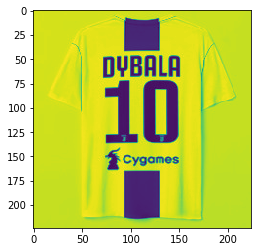

2042


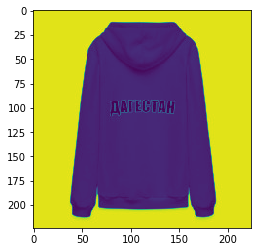

3041


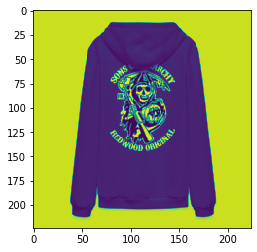

3059


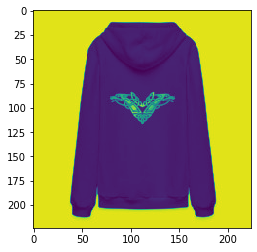

3072


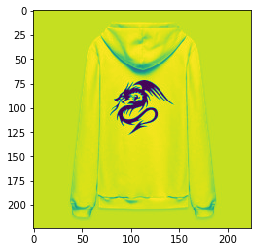

3125


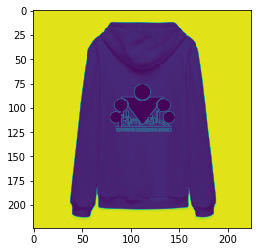

3146


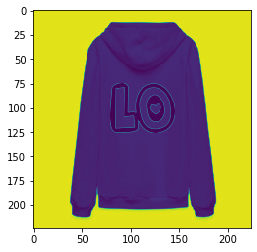

3176


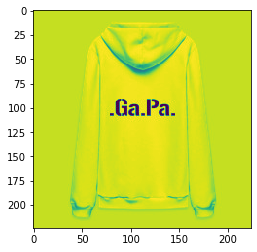

3204


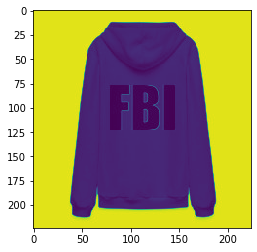

3206


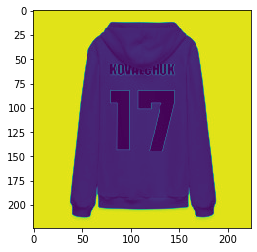

3209


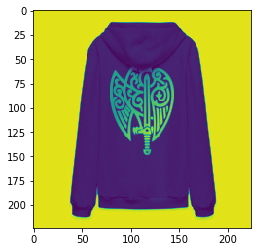

3216


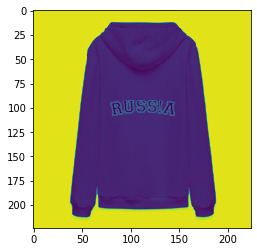

3254


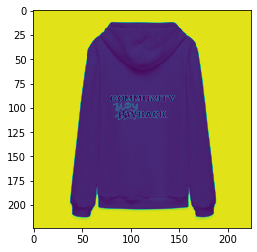

3256


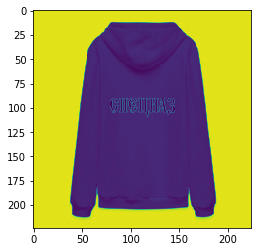

3270


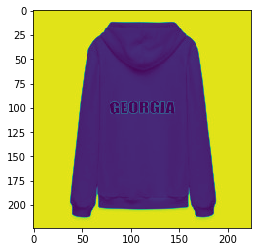

3308


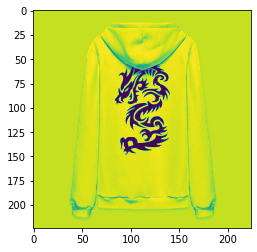

3323


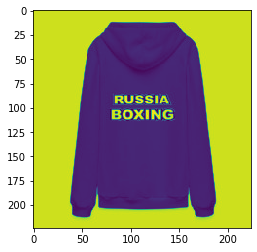

3330


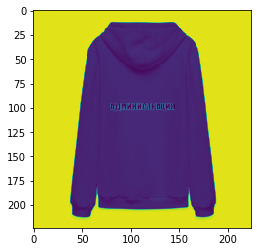

3334


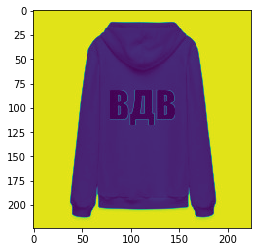

3362


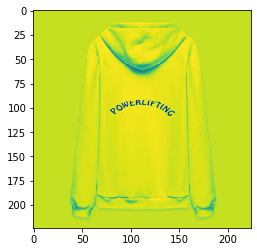

3372


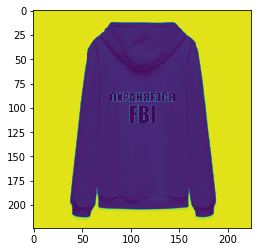

3417


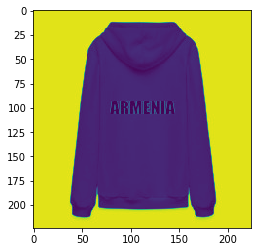

3464


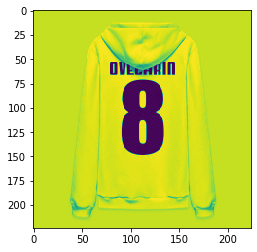

3529


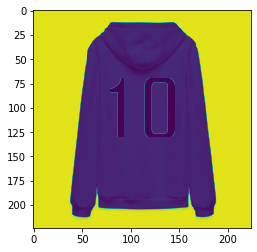

3627


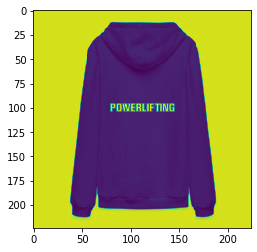

3645


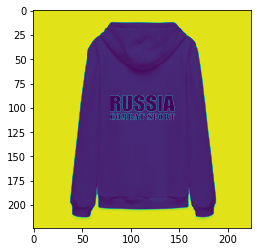

3764


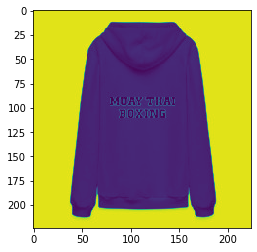

3818


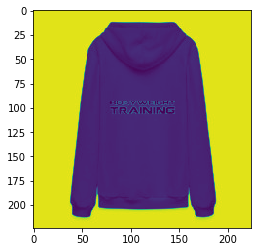

In [8]:
# получаем вектор
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
import numpy as np
import os
vec = []
i = 0

for img in images:
    try:
        x = image.img_to_array(img)  
        x = np.expand_dims(x, axis=0)  
        x = preprocess_input(x)
        vec.append(model.predict(x).ravel())
        i += 1
    except: 
#         del images[i]
        print(i)
        plt.imshow(img)
        plt.show()
        i += 1
        vec.append([0 for i in range(4096)])

In [9]:
print((time.time() - start_time)/60, 'мин')
start_time = time.time()

41.19727220932643 мин


In [10]:
# считаю расстояния
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(p=2, metric='minkowski')
knn.fit(vec)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [11]:
# дистанция и топ ближайших векторов
dist, indices = knn.kneighbors(vec, n_neighbors=6)

In [12]:
# вывод рекомендаций
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt
def rec_sist(k):
    for i in indices[k]:
        plt.imshow(images[i])
        plt.show()

5149


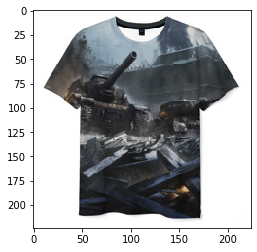

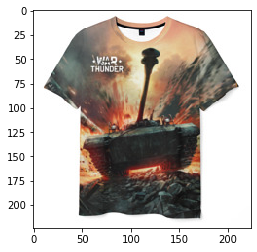

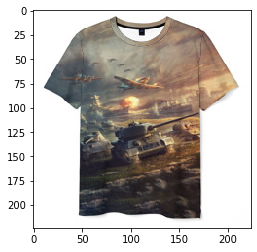

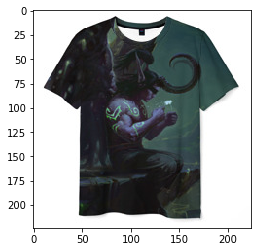

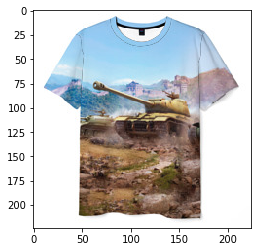

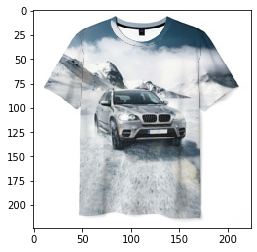

In [233]:
import random
number = random.randint(0, len(images)-1)
print(number)
rec_sist(1414)

In [14]:
print(len(images))

5840
